In [ ]:

# Colab setup: Upload and extract zip dataset
from google.colab import files
import zipfile
import os

# Upload the zip file (user interaction required)
uploaded = files.upload()

# Extract the zip file (assuming only one file uploaded)
for filename in uploaded.keys():
    if filename.endswith(".zip"):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("/content/Corn_Leaf_Disease_Dataset")
        print(f"Extracted {filename} to /content/Corn_Leaf_Disease_Dataset")
        dataset_path = "/content/Corn_Leaf_Disease_Dataset"
    else:
        raise ValueError("Please upload a .zip file containing image folders")

Saving archive (2).zip to archive (2) (1).zip
Extracted archive (2) (1).zip to /content/Corn_Leaf_Disease_Dataset


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
import os

dataset_path = "/content/Corn_Leaf_Disease_Dataset/Corn_Leaf_Disease_Dataset"
print(os.listdir(dataset_path))

['Common_Rust', 'Gray_Leaf_Spot', 'Healthy', 'Blight']


In [ ]:

# Step CNN: CNN-Based Disease Detection
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

# Define image size and batch size
img_height, img_width = 32, 32
batch_size = 32

# Data generators for training and validation
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Building the CNN model
model = Sequential([
    Conv2D(15, (3, 3), input_shape=(img_height, img_width, 3), activation='relu'),  # Step 3: 15 filters
    MaxPooling2D(pool_size=(2, 2)),  # Step 5: Pooling
    Flatten(),
    Dense(64, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Step 6: Classify
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model training
history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

# Step 7: Predict and display disease symptoms
import random





Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.6140 - loss: 0.9648 - val_accuracy: 0.8002 - val_loss: 0.4608
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.8254 - loss: 0.4541 - val_accuracy: 0.8134 - val_loss: 0.4270
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.8359 - loss: 0.3928 - val_accuracy: 0.8170 - val_loss: 0.4024
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8493 - loss: 0.3852 - val_accuracy: 0.8014 - val_loss: 0.4480
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.8564 - loss: 0.3444 - val_accuracy: 0.8194 - val_loss: 0.3951


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


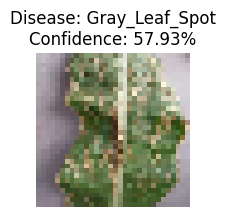

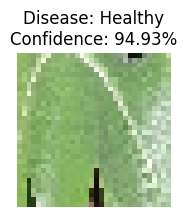

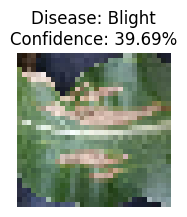

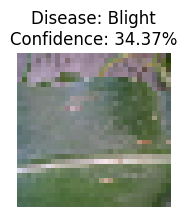

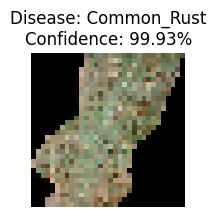

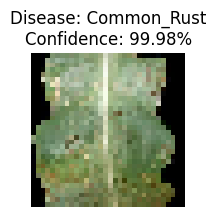

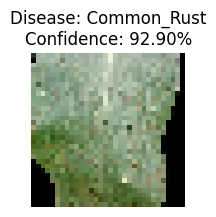

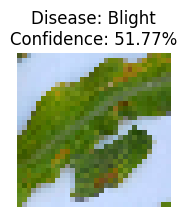

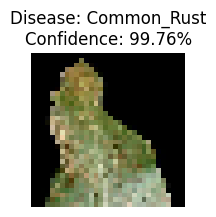

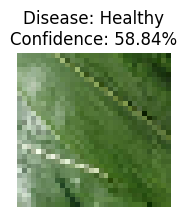

In [ ]:
# CNN-Based Final Output: Display predictions of disease symptoms (class + confidence)
import matplotlib.pyplot as plt
import numpy as np

def display_predictions(generator, model, num_images=10):
    class_labels = list(generator.class_indices.keys())
    images, labels = next(generator)
    predictions = model.predict(images)

    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(2, 2))
        plt.imshow(images[i])
        predicted_class = class_labels[np.argmax(predictions[i])]
        confidence = np.max(predictions[i]) * 100
        plt.title(f"Disease: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.axis('off')
        plt.show()

# Call the function with validation generator (defined earlier)
display_predictions(validation_generator, model)


In [ ]:
# CNN Accuracy
val_loss, val_acc = model.evaluate(validation_generator)
print(f"CNN Accuracy: {val_acc * 100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8207 - loss: 0.4001
CNN Accuracy: 81.94%


In [ ]:
print("Class indices:", train_generator.class_indices)
print("Number of training images:", train_generator.samples)
print("Number of validation images:", validation_generator.samples)

train_classes = train_generator.classes
val_classes = validation_generator.classes

print("Train class distribution:", np.bincount(train_classes))
print("Validation class distribution:", np.bincount(val_classes))

# --- Feature Extraction for SVMs ---
print("\n--- Extracting Features for SVM Models ---")

def extract_features(generator):
    features = []
    labels = []
    for _ in range(len(generator)):
        batch_images, batch_labels = next(generator)
        batch_features = batch_images.reshape(batch_images.shape[0], -1)  # Flatten
        features.append(batch_features)
        labels.append(np.argmax(batch_labels, axis=1))
    return np.vstack(features), np.hstack(labels)

X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print("Classes in y_train:", np.unique(y_train))
print("Classes in y_val:", np.unique(y_val))

if len(np.unique(y_train)) < 2 or len(np.unique(y_val)) < 2:
    raise ValueError("Training and validation sets must each contain at least two classes for SVM.")

# --- Plain SVM ---

svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_val)
svm_accuracy = accuracy_score(y_val, svm_preds)
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")

# --- ENSVM using Bagging ---
ensvm_model = BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=10, random_state=42)
ensvm_model.fit(X_train, y_train)
ensvm_preds = ensvm_model.predict(X_val)
ensvm_accuracy = accuracy_score(y_val, ensvm_preds)
print(f"ENSVM Accuracy: {ensvm_accuracy * 100:.2f}%")


Class indices: {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
Number of training images: 3352
Number of validation images: 836
Train class distribution: [ 917 1045  460  930]
Validation class distribution: [229 261 114 232]

--- Extracting Features for SVM Models ---
Training features shape: (3352, 3072)
Validation features shape: (836, 3072)
Classes in y_train: [0 1 2 3]
Classes in y_val: [0 1 2 3]
SVM Accuracy: 83.25%
ENSVM Accuracy: 82.54%


Class mapping: {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
Class mapping: {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}

--- Dataset Summary ---
Number of training samples: 1200
Number of testing samples: 400
Training class distribution: [300 300 300 300]
Testing class distribution: [100 100 100 100]

✅ Linear SVM Accuracy: 92.25%

Classification Report:
                precision    recall  f1-score   support

        Blight       0.84      0.87      0.86       100
   Common_Rust       1.00      1.00      1.00       100
Gray_Leaf_Spot       0.88      0.85      0.86       100
       Healthy       0.97      0.97      0.97       100

      accuracy                           0.92       400
     macro avg       0.92      0.92      0.92       400
  weighted avg       0.92      0.92      0.92       400



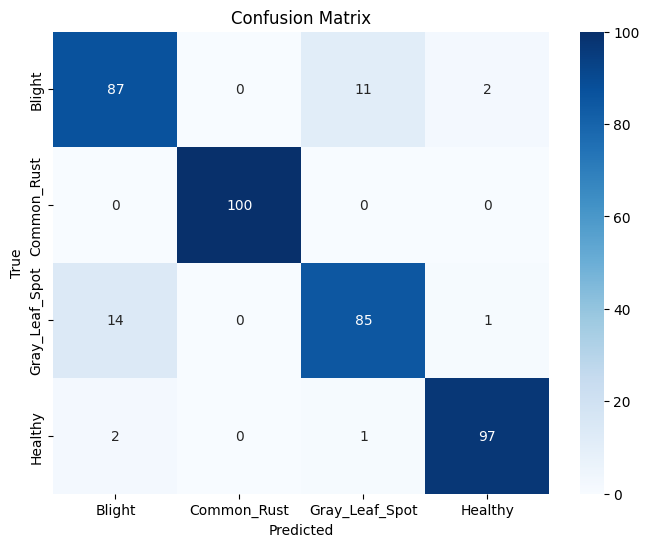

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce image size to save memory
IMAGE_SIZE = (32, 32)
USE_POLY = False  # Set to True only if dataset is small or RAM is sufficient

def load_data(folder_path, image_size=IMAGE_SIZE, max_per_class=None):
    data = []
    labels = []
    class_names = sorted(os.listdir(folder_path))
    class_map = {cls: idx for idx, cls in enumerate(class_names)}
    print("Class mapping:", class_map)

    for cls in class_names:
        cls_path = os.path.join(folder_path, cls)
        if not os.path.isdir(cls_path):
            continue
        count = 0
        for img_name in os.listdir(cls_path):
            if max_per_class and count >= max_per_class:
                break
            try:
                img_path = os.path.join(cls_path, img_name)
                img = Image.open(img_path).convert('L')  # Grayscale
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize
                data.append(img_array.flatten())
                labels.append(class_map[cls])
                count += 1
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue
    return np.array(data), np.array(labels), class_names

# --- SAFER PATH for RAM ---
train_path = "/content/Corn_Leaf_Disease_Dataset/Corn_Leaf_Disease_Dataset/"
test_path = "/content/Corn_Leaf_Disease_Dataset/Corn_Leaf_Disease_Dataset/"

# Limit images per class to avoid RAM crash (remove `max_per_class` later if needed)
X_train, y_train, class_names = load_data(train_path, max_per_class=300)
X_test, y_test, _ = load_data(test_path, max_per_class=100)

print("\n--- Dataset Summary ---")
print("Number of training samples:", len(y_train))
print("Number of testing samples:", len(y_test))
print("Training class distribution:", np.bincount(y_train))
print("Testing class distribution:", np.bincount(y_test))

# Optional polynomial features (disabled to save RAM)
if USE_POLY:
    poly = PolynomialFeatures(degree=2)
    X_train = poly.fit_transform(X_train)
    X_test = poly.transform(X_test)

# Train Linear SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Evaluate
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Linear SVM Accuracy: {acc * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



🎯 Random Forest Accuracy: 96.92%

Classification Report:
                precision    recall  f1-score   support

        Blight       0.90      1.00      0.95      1146
   Common_Rust       1.00      0.99      1.00      1306
Gray_Leaf_Spot       1.00      0.86      0.92       574
       Healthy       1.00      0.97      0.98      1162

      accuracy                           0.97      4188
     macro avg       0.97      0.95      0.96      4188
  weighted avg       0.97      0.97      0.97      4188



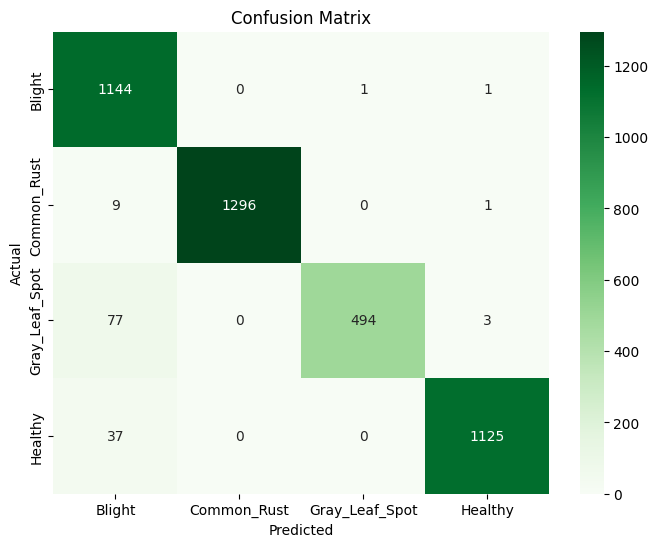

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# SETTINGS
IMAGE_SIZE = (32, 32)  # Lower size for memory and speed
train_path = "/content/Corn_Leaf_Disease_Dataset/Corn_Leaf_Disease_Dataset/"
test_path = "/content/Corn_Leaf_Disease_Dataset/Corn_Leaf_Disease_Dataset/"

def load_dataset(path, max_per_class=None):
    data = []
    labels = []
    class_names = sorted(os.listdir(path))
    label_map = {cls: i for i, cls in enumerate(class_names)}

    for cls in class_names:
        cls_folder = os.path.join(path, cls)
        if not os.path.isdir(cls_folder):
            continue
        count = 0
        for file in os.listdir(cls_folder):
            if max_per_class and count >= max_per_class:
                break
            try:
                img_path = os.path.join(cls_folder, file)
                img = Image.open(img_path).convert('L')  # Grayscale
                img = img.resize(IMAGE_SIZE)
                img_array = np.array(img) / 255.0  # Normalize
                data.append(img_array.flatten())
                labels.append(label_map[cls])
                count += 1
            except:
                continue
    return np.array(data), np.array(labels), class_names

# LOAD DATA
X_train, y_train, class_names = load_dataset(train_path)
X_test, y_test, _ = load_dataset(test_path)

# PREPROCESSING (standard scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODEL
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# PREDICTION
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

# RESULTS
print(f"\n🎯 Random Forest Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# CONFUSION MATRIX
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names, cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
